<a href="https://colab.research.google.com/github/Wahyu-Siregar/Analysis_marga_batak/blob/main/Analysis_marga_batak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Ganti path sesuai lokasi file di Google Drive kamu
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Dataset/marga_batak_optimized.csv')

# Preview data
df.head()
df.info()
df.describe(include='all')

### DATA CLEANING

In [54]:
# Cek nilai kosong per kolom
print(df.isnull().sum())

# Cek duplikat baris
print("Jumlah duplikat:", df.duplicated().sum())

"No (Text)"            0
"Marga (Text)"         0
"Marga (Link)"         0
"Angkola (Text)"       0
"Karo (Text)"          0
"Mandailing (Text)"    0
"Pakpak (Text)"        0
"Simalungun (Text)"    0
"Toba (Text)"          0
"Keterangan (Text)"    0
"Description"          0
dtype: int64
Jumlah duplikat: 0


In [60]:
# Hilangkan spasi di awal/akhir semua kolom string (versi terbaru)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.strip()

In [61]:
for col in ['"Marga (Text)"', '"Description"']:
    df[col] = df[col].str.lower()

In [62]:
for col in ['"Angkola (Text)"', '"Karo (Text)"', '"Mandailing (Text)"', '"Pakpak (Text)"', '"Simalungun (Text)"', '"Toba (Text)"']:
    print(col, df[col].unique())

"Angkola (Text)" ['"T"' '"Y"']
"Karo (Text)" ['"Y"' '"T"']
"Mandailing (Text)" ['"T"' '"Y"']
"Pakpak (Text)" ['"T"' '"Y"']
"Simalungun (Text)" ['"T"' '"Y"']
"Toba (Text)" ['"T"' '"Y"']


### **Analisis Distribusi Label**

In [63]:
for col in ['"Angkola (Text)"', '"Karo (Text)"', '"Mandailing (Text)"', '"Pakpak (Text)"', '"Simalungun (Text)"', '"Toba (Text)"']:
    print(f"{col}:")
    print(df[col].value_counts())
    print()

"Angkola (Text)":
"Angkola (Text)"
"T"    330
"Y"     19
Name: count, dtype: int64

"Karo (Text)":
"Karo (Text)"
"T"    273
"Y"     76
Name: count, dtype: int64

"Mandailing (Text)":
"Mandailing (Text)"
"T"    327
"Y"     22
Name: count, dtype: int64

"Pakpak (Text)":
"Pakpak (Text)"
"T"    301
"Y"     48
Name: count, dtype: int64

"Simalungun (Text)":
"Simalungun (Text)"
"T"    287
"Y"     62
Name: count, dtype: int64

"Toba (Text)":
"Toba (Text)"
"Y"    188
"T"    161
Name: count, dtype: int64



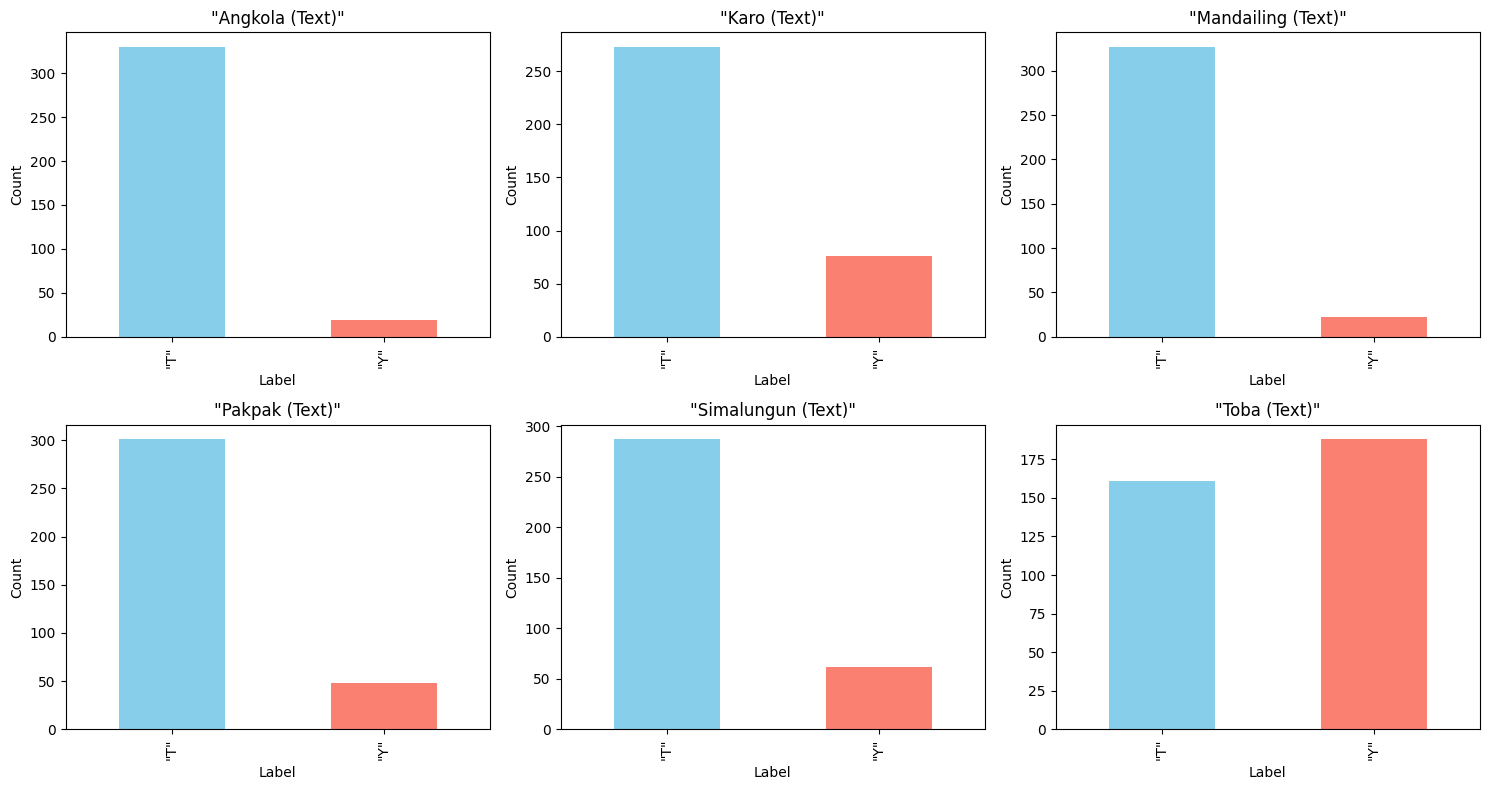

In [64]:
import matplotlib.pyplot as plt

# List kolom label
label_cols = ['"Angkola (Text)"', '"Karo (Text)"', '"Mandailing (Text)"', '"Pakpak (Text)"', '"Simalungun (Text)"', '"Toba (Text)"']

# Plot bar chart untuk setiap label
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(label_cols):
    df[col].value_counts().sort_index().plot(kind='bar', ax=axes[i], color=['skyblue', 'salmon'])
    axes[i].set_title(col)
    axes[i].set_xlabel('Label')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### **Split Train/Test**

In [65]:
from sklearn.model_selection import train_test_split

# Fitur: gunakan "Description" (bisa tambah "Marga (Text)" jika mau)
X = df[['"Marga (Text)"', '"Description"']]
# Label: 6 kolom sub-etnis
y = df[['"Angkola (Text)"', '"Karo (Text)"', '"Mandailing (Text)"', '"Pakpak (Text)"', '"Simalungun (Text)"', '"Toba (Text)"']]

# Split data (stratify pada salah satu label, misal "Toba (Text)")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y['"Toba (Text)"']
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (279, 2) (279, 6)
Test shape: (70, 2) (70, 6)


### **Feature Engineering**

In [67]:
# Ubah label Y/T ke 1/0 untuk seluruh DataFrame
def encode_yt(df):
    return df.apply(lambda col: col.map(lambda x: 1 if x == '"Y"' else 0))

y_train_bin = encode_yt(y_train)
y_test_bin = encode_yt(y_test)

### **Ekstraksi Fitur Teks (TF-IDF)**

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi vectorizer
vect = TfidfVectorizer(ngram_range=(1,2), max_features=5000)

# Fit di data train, transform train & test
X_train_text = vect.fit_transform(X_train['"Description"'])
X_test_text = vect.transform(X_test['"Description"'])

print("X_train_text shape:", X_train_text.shape)
print("X_test_text shape:", X_test_text.shape)

X_train_text shape: (279, 3608)
X_test_text shape: (70, 3608)


### **Random Forest (MultiOutputClassifier)**

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Inisialisasi model Random Forest
rf_clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))

# Training
rf_clf.fit(X_train_text, y_train_bin)

# Prediksi di test set
y_pred_rf = rf_clf.predict(X_test_text)

### **SVM (LinearSVC, MultiOutputClassifier)**

In [73]:
from sklearn.svm import LinearSVC

# Inisialisasi model LinearSVC
svm_clf = MultiOutputClassifier(LinearSVC(max_iter=2000, random_state=42))

# Training
svm_clf.fit(X_train_text, y_train_bin)

# Prediksi di test set
y_pred_svm = svm_clf.predict(X_test_text)

### **Evaluasi (Classification Report)**

In [74]:
from sklearn.metrics import classification_report

print("Random Forest:")
print(classification_report(y_test_bin, y_pred_rf, target_names=y_test_bin.columns))

print("LinearSVC:")
print(classification_report(y_test_bin, y_pred_svm, target_names=y_test_bin.columns))

Random Forest:
                     precision    recall  f1-score   support

   "Angkola (Text)"       0.00      0.00      0.00         1
      "Karo (Text)"       0.88      0.35      0.50        20
"Mandailing (Text)"       1.00      0.50      0.67         2
    "Pakpak (Text)"       0.75      0.43      0.55         7
"Simalungun (Text)"       0.83      0.31      0.45        16
      "Toba (Text)"       0.87      0.89      0.88        38

          micro avg       0.86      0.60      0.70        84
          macro avg       0.72      0.41      0.51        84
       weighted avg       0.85      0.60      0.67        84
        samples avg       0.68      0.61      0.63        84

LinearSVC:
                     precision    recall  f1-score   support

   "Angkola (Text)"       0.00      0.00      0.00         1
      "Karo (Text)"       0.88      0.35      0.50        20
"Mandailing (Text)"       1.00      0.50      0.67         2
    "Pakpak (Text)"       0.67      0.29      0.40     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

### **Pipeline (Random Forest)**

In [75]:
from sklearn.pipeline import Pipeline

# Pipeline dengan Random Forest (model terbaik)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42)))
])

# Fit pipeline dengan data mentah (teks)
X_train_raw = X_train['"Description"']
pipeline.fit(X_train_raw, y_train_bin)

# Prediksi dengan pipeline
y_pred_pipe = pipeline.predict(X_test['"Description"'])

# Evaluasi
print("Pipeline (Random Forest):")
print(classification_report(y_test_bin, y_pred_pipe, target_names=y_test_bin.columns))

Pipeline (Random Forest):
                     precision    recall  f1-score   support

   "Angkola (Text)"       0.00      0.00      0.00         1
      "Karo (Text)"       0.88      0.35      0.50        20
"Mandailing (Text)"       1.00      0.50      0.67         2
    "Pakpak (Text)"       0.75      0.43      0.55         7
"Simalungun (Text)"       0.83      0.31      0.45        16
      "Toba (Text)"       0.87      0.89      0.88        38

          micro avg       0.86      0.60      0.70        84
          macro avg       0.72      0.41      0.51        84
       weighted avg       0.85      0.60      0.67        84
        samples avg       0.68      0.61      0.63        84



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Hyperparameter Tuning**

In [76]:
from sklearn.model_selection import GridSearchCV

# Parameter untuk Random Forest (versi sederhana agar tidak terlalu lama)
param_grid = {
    'clf__estimator__n_estimators': [50, 100],
    'clf__estimator__max_depth': [None, 20],
    'tfidf__max_features': [3000, 5000]
}

# Grid Search
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_micro')
grid.fit(X_train_raw, y_train_bin)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

# Prediksi dengan model terbaik
y_pred_best = grid.best_estimator_.predict(X_test['"Description"'])
print("\nBest model performance:")
print(classification_report(y_test_bin, y_pred_best, target_names=y_test_bin.columns))

Best parameters: {'clf__estimator__max_depth': None, 'clf__estimator__n_estimators': 100, 'tfidf__max_features': 3000}
Best score: 0.6690659630959784

Best model performance:
                     precision    recall  f1-score   support

   "Angkola (Text)"       0.00      0.00      0.00         1
      "Karo (Text)"       0.78      0.35      0.48        20
"Mandailing (Text)"       1.00      0.50      0.67         2
    "Pakpak (Text)"       0.67      0.29      0.40         7
"Simalungun (Text)"       0.80      0.25      0.38        16
      "Toba (Text)"       0.89      0.87      0.88        38

          micro avg       0.85      0.56      0.68        84
          macro avg       0.69      0.38      0.47        84
       weighted avg       0.82      0.56      0.63        84
        samples avg       0.65      0.60      0.61        84



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
